*Install required library *

In [1]:
!pip install -q supervision "ultralytics<=8.3.40"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.6 MB/s eta 0:00:00


In [2]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Path Configuration

In [5]:
SOURCE_VIDEO_PATH = "/content/carLicence4.mp4"
TARGET_VIDEO_PATH = "/content/vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

In [6]:
SOURCE = np.array([
    [1252, 787],
    [2298, 803],
    [5039, 2159],
    [-550, 2159]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [7]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

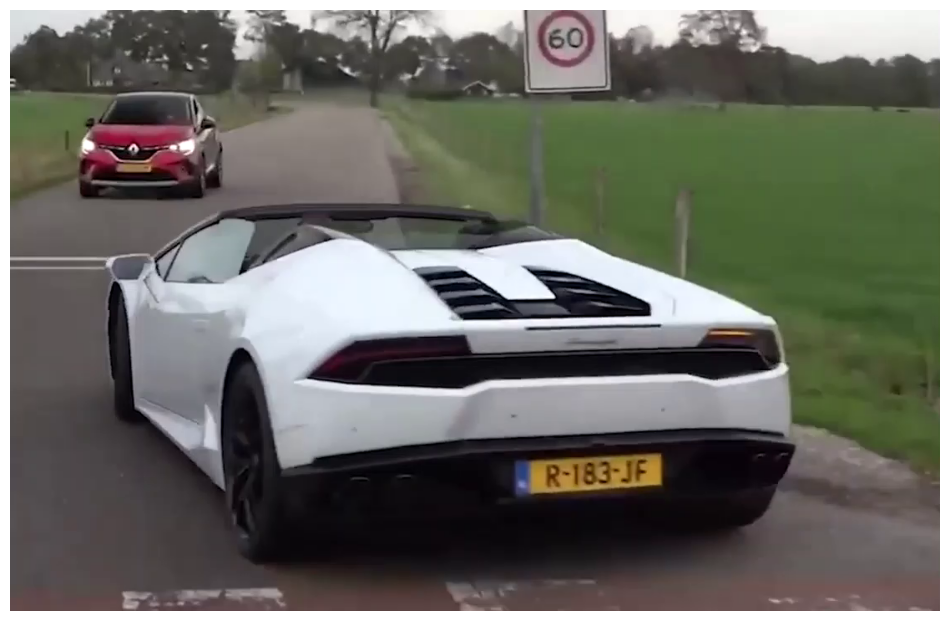

In [8]:
import supervision as sv

annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.RED, thickness=4)
sv.plot_image(annotated_frame)


In [9]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [11]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO
from collections import defaultdict, deque
from tqdm import tqdm
from google.colab import files

# Load YOLO model
MODEL_NAME = "yolov8x.pt"
model = YOLO(MODEL_NAME)

# Define video paths
SOURCE_VIDEO_PATH = "/content/carLicence4.mp4"  # Change if needed
TARGET_VIDEO_PATH = "/content/output.mp4"

# Load video information
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Initialize ByteTrack tracker
byte_track = sv.ByteTrack()

# Manually set thickness and text scale based on video resolution
thickness = max(1, int(min(video_info.resolution_wh) / 400))  # Adjust line thickness dynamically
text_scale = max(0.5, min(video_info.resolution_wh) / 1000)   # Adjust text size dynamically

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Define ROI transformation points (Adjust these for your scene)
SOURCE = np.array([
    [1252, 787],
    [2298, 803],
    [5039, 2159],
    [-550, 2159]
])

TARGET = np.array([
    [0, 0],
    [24, 0],
    [24, 249],
    [0, 249],
])

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points
        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

# Initialize View Transformer
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

# Dictionary to store past coordinates
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Open output video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # Perform YOLO detection
        result = model(frame, imgsz=640, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter detections based on confidence threshold
        CONFIDENCE_THRESHOLD = 0.3
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]

        # Track objects
        detections = byte_track.update_with_detections(detections=detections)

        # Get detection points
        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Apply perspective transformation
        points = view_transformer.transform_points(points=points).astype(int)

        # Store coordinates for speed calculation
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Calculate speed
        labels = []
        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6  # Convert to km/h
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        # Write frame to output video
        sink.write_frame(annotated_frame)

print("✅ Processing complete! Check output video:", TARGET_VIDEO_PATH)

# Download the processed video
files.download(TARGET_VIDEO_PATH)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
100%|██████████| 631/631 [34:27<00:00,  3.28s/it]

✅ Processing complete! Check output video: /content/output.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>